## Table of contents
1. [Import Libraries](#imports)
2. [Load Data](#load-data)
3. [Pre-processing: Scans](#scan-info)
4. [Pre-processing: Errors](#error-info)
5. [Motor 1 EDA](#Visualizations)
6. [Motor 2 EDA](#Resampling)<br>
7. [Conversion: Time Delay](#Decomposition)
8. [Time Series Stationarity](#Time-Series-Stationarity)
9. [Making Time Series Stationary](#Making-Time-Series-Stationary)
10. [Autocorrelations and Partial Autocorrelations](#Autocorrelations-and-Partial-Autocorrelations)
11. [ARIMA Modeling](#ARIMA-Modeling)
12. [Conclusion](#Conclusion)

### Import Libraries and Modules


In [95]:
# Data Manipulation, Wrangling & Analysis Library 
import pandas as pd
# Multi-Dimensional Arrays and Matrices Library
import numpy as np
# Plotting module from Matplotlib visualization Library
import matplotlib.pyplot as plt
# Statistical data visualization library built on Matplotlib
import seaborn as sns
# Import physical constants such as the speed of light
import scipy.constants as consts

In [96]:
# Import axes_grid1 toolkit to display multiplot w/ AxesGrid helper class
from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.axes_grid1 import host_subplot

In [97]:
# Quick and dirty method
import plotly.express as px

# For more customization
import plotly.graph_objects as go

# Make subplots
from plotly.subplots import make_subplots

#### Render Plotly graphs in JupyterLab Notebook
[*Stack Overflow*](https://stackoverflow.com/questions/54936125/plotly-gives-an-empty-field-as-output-in-jupyter-lab)

JupyterLab Version >= 3.0.0:<br> 
$ jupyter labextension install jupyterlab-plotly

Verify:<br>
$ jupyter labextension list

---
### Load Data

[[ go back to the top ]](#Table-of-contents)

In [98]:
# Identify column names for new DataFrame
header_names = ['#errors',
                'scan#', 
                'motor-target_1', # Motor-1 targeted motor position
                'motor-target_2', # Motor-2 targeted motor position
                'motor-actual_1', # Motor-1 actual recorded position
                'motor-actual_2', # Motor-2 actual recorded position
                'data_channel_0', 
                'data_channel_1', 
                'data_channel_2',
                'data_channel_3',
                'data_channel_4',
                'data_channel_5',
                'data_channel_6',
                'data_channel_7']

# Read tsv data and assign to a Pandas DataFrame
data = pd.read_csv('../data/trial_output05.tsv', delimiter='\t', names = header_names)

#### Check that all is copacetic

[[ go back to the top ]](#Table-of-contents)

In [99]:
# motor-target_1: Corresponds to Delay-Axis 1 "T"  PUMP TO DRIVE/PROBE PAIR
# motor-target_2: Corresponds to Delay-Axis 2 "Tau" DRIVE TO PROBE
data.describe()

,#errors,scan#,motor-target_1,motor-target_2,motor-actual_1,motor-actual_2,data_channel_0,data_channel_1,data_channel_2,data_channel_3,data_channel_4,data_channel_5,data_channel_6,data_channel_7
count,45628.0,45628.000000,45628.000000,45628.000000,45628.000000,45628.000000,45628.000000,45628.000000,45628.000000,45628.000000,45628.000000,45628.000000,45628.000000,45628.000000
mean,0.0,5.378978,9.314018,33.425522,9.314025,33.425522,-0.005923,-0.006613,-0.006294,-0.006124,-0.007194,-0.006101,-0.021113,0.004937
std,0.0,3.390998,0.058022,0.050232,0.058011,0.050232,0.006699,0.022854,0.005250,0.010072,0.022253,0.009477,0.014158,0.015740
min,0.0,0.000000,9.215000,33.340000,9.215000,33.340000,-0.032503,-0.063398,-0.031538,-0.047629,-0.058893,-0.037974,-0.032503,-0.025745
25%,0.0,2.000000,9.263000,33.382000,9.263000,33.382000,-0.010298,-0.027033,-0.009654,-0.013194,-0.027033,-0.012229,-0.022849,0.003219
50%,0.0,5.000000,9.314000,33.427000,9.314000,33.427000,-0.006436,-0.008689,-0.006436,-0.007080,-0.009976,-0.007401,-0.021240,0.004828
75%,0.0,8.000000,9.365000,33.469000,9.365000,33.469000,-0.000965,0.012873,-0.002252,0.000644,0.011586,0.001288,-0.019631,0.006115
max,0.0,11.000000,9.413000,33.511000,9.413100,33.511000,0.018022,0.059537,0.016735,0.039906,0.056963,0.025424,1.671540,1.827301


---
### Identify number of complete scans performed


[[ go back to the top ]](#Table-of-contents)

In [100]:
# Scans are averaged together, homodyne OKE results

# Count the number of measurements taken in each scan
m1_step_count = len(data['motor-target_1'].value_counts())
# Count the number of measurements taken in each scan
m2_step_count = len(data['motor-target_2'].value_counts())

# Requirements for complete scan
print(f'Complete scans have {m1_step_count*m2_step_count:,} measurements!\n')

print('Scan #\t% Complete')
display(round((data['scan#'].value_counts().sort_index()/(m1_step_count*m2_step_count))*100, 2))

# Identify scans to drop from analysis


Complete scans have 3,886 measurements!

Scan #	% Complete


0.0     100.00
1.0     100.00
2.0     100.00
3.0     100.00
4.0     100.00
5.0     100.00
6.0     100.00
7.0     100.00
8.0     100.00
9.0     100.00
10.0    100.00
11.0     74.16
Name: scan#, dtype: float64

### Check for Errors

[[ go back to the top ]](#Table-of-contents)

In [101]:
# No errors identified in 45,628 measurements!
# An error may consist of a communication error b/w motor & acquisition computer
# Motors will be reinitialized, and the scan is restarted
data['#errors'].value_counts()

0.0    45628
Name: #errors, dtype: int64

---
### EDA: Characterize each Delay-Axis by Motor-Position(target)
* How many measurements were taken?
* What range was covered?
* What is the step-size of each scan?

[[ go back to the top ]](#Table-of-contents)

#### A.) Consider Motor-1 Targets

In [102]:
# Display Motor_1 
print(f'Motor-1 Targets: \n')

# Determine the range of Motor_1 positions
m1_position_min = min(data['motor-target_1'])
m1_position_max = max(data['motor-target_1'])
m1_position_range = m1_position_max - m1_position_min

print(f'\
        Min: {m1_position_min}[mm]\n\
        Max: {m1_position_max}[mm]\n\
        Range: {m1_position_range:.4f}[mm]')

# Display the number of measurements taken in each scan
print(f'\tNo. of Steps: {m1_step_count}')

Motor-1 Targets: 

        Min: 9.215[mm]
        Max: 9.413[mm]
        Range: 0.1980[mm]
	No. of Steps: 67


#### B.) Consider Motor-2 Targets

In [103]:
# Motor_2 positions range (9.215, 9.413)
print(f'Motor-2 Targets: \n')

# Determine the range of Motor_1 positions
m2_position_min = min(data['motor-target_2'])
m2_position_max = max(data['motor-target_2'])
m2_position_range = m2_position_max - m2_position_min

print(f'\
        Min: {m2_position_min}[mm]\n\
        Max: {m2_position_max}[mm]\n\
        Range: {m2_position_range:.4f}[mm]')

# Display the number of measurements taken in each scan
print(f'\tNo. of Steps: {m2_step_count}')

Motor-2 Targets: 

        Min: 33.34[mm]
        Max: 33.511[mm]
        Range: 0.1710[mm]
	No. of Steps: 58


---
### Conversion: Motor-Position [mm] to Time-Delay [fs]

[[ go back to the top ]](#Table-of-contents)

#### A) Delay Axis-1: T 
##### Delay between the excitation(pump) pulse and subsequent pulses

In [104]:
# Step-size for Delay Axis-1
step1_space = m1_position_range/m1_step_count

# Time, in femtoseconds[fs], it takes light to travel twice the distance "step_1"

step1_time = ((step1_space*2)/(consts.c*1000))/(1E-15)
range_T = step1_time*m1_step_count

print(f'Motor-1 step-size: {step1_space:.3f}[mm] or ~ {step1_time:.1f}[fs]')
print(f'Pump-Probe Time Delay T range:  ~{range_T:,.0f}[fs]')

Motor-1 step-size: 0.003[mm] or ~ 19.7[fs]
Pump-Probe Time Delay T range:  ~1,321[fs]


#### B) Delay Axis-2: <font size="5">$\tau$</font>
##### Delay between Kerr-Gating(drive) pulse and probe pulse

In [105]:
# Step-size for Delay Axis-2
step2_space = m2_position_range/m2_step_count

# Time [femtoseconds] it takes light to travel twice the distance "step_2"
step2_time = ((step2_space*2)/(consts.c*1000))/(1E-15)
range_tau = step2_time*m2_step_count

print(f'Motor-2 step-size: {step2_space:.3f}[mm] or   ~ {step2_time:.1f}[fs]')
print(f'Drive-Probe Time Delay tau range: ~{range_tau:,.0f}[fs]')

Motor-2 step-size: 0.003[mm] or   ~ 19.7[fs]
Drive-Probe Time Delay tau range: ~1,141[fs]


---

In [106]:
# Identify range of signal amplitudes
data_cols = [col_name for col_name in data if 'data_channel' in col_name]
signal_df = data[data_cols]
v_min = min(signal_df.min())
v_max = max(signal_df.max())
print(f'Minimum: {v_min}\nMaximum: {v_max}')

Minimum: -0.063398
Maximum: 1.827301


In [107]:
signal_mins = []
signal_maxs = []
for col in signal_df.columns:
    signal_mins.append(round(min(signal_df[col]),4))
    signal_maxs.append(round(max(signal_df[col]),4))
display(signal_mins, signal_maxs)

[-0.0325, -0.0634, -0.0315, -0.0476, -0.0589, -0.038, -0.0325, -0.0257]

[0.018, 0.0595, 0.0167, 0.0399, 0.057, 0.0254, 1.6715, 1.8273]

In [108]:
signal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45628 entries, 0 to 45627
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   data_channel_0  45628 non-null  float64
 1   data_channel_1  45628 non-null  float64
 2   data_channel_2  45628 non-null  float64
 3   data_channel_3  45628 non-null  float64
 4   data_channel_4  45628 non-null  float64
 5   data_channel_5  45628 non-null  float64
 6   data_channel_6  45628 non-null  float64
 7   data_channel_7  45628 non-null  float64
dtypes: float64(8)
memory usage: 2.8 MB


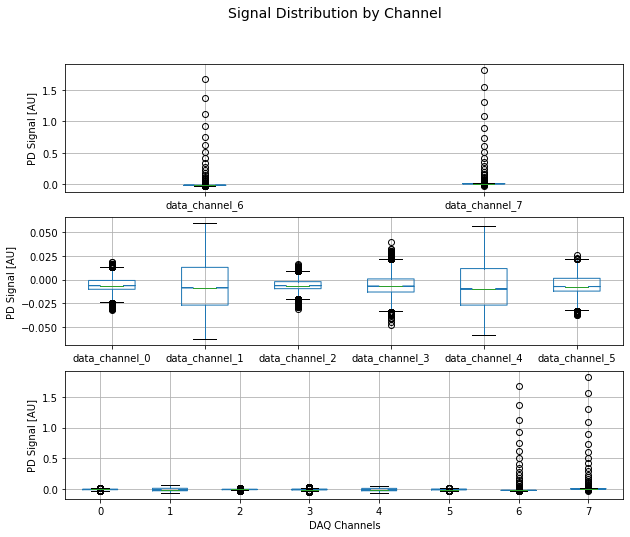

In [109]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3,
                               ncols = 1,
                               sharex=False,
                               figsize = (10, 8));

sig_df = signal_df.drop(columns=['data_channel_6', 'data_channel_7']).copy()
s_df = signal_df.drop(columns=[list(signal_df.columns)[col] for col in range(len(signal_df.columns)-2)]).copy()

s_df.boxplot(notch=True, ax = ax1)
sig_df.boxplot(notch=True, ax = ax2)
signal_df.boxplot(notch=True, ax = ax3)#, labels = [titles[targets[i]] for i in range(len(targets))])

# AU = arbitrary units, PD = photodiode
ax1.set_ylabel(f'PD Signal [AU]')
ax2.set_ylabel(f'PD Signal [AU]')
ax3.set_ylabel(f'PD Signal [AU]')
plt.xlabel(f'DAQ Channels')
ax3.set_xticklabels(labels=[i for i in range(len(signal_df.columns))] )
#plt.setp( axs.get_xticklabels(), rotation = 0, rotation_mode='anchor', ha='center');
#plt.setp( axs.get_yticklabels(), rotation = 0, rotation_mode='anchor', ha='center');
plt.suptitle(t = f'Signal Distribution by Channel', fontsize=14);
#plt.legend(labels, loc = 'upper center')

#### Figure: 
> Box & Whisker subplot showing a static glance of amplitude-distributions related to changes in the probe's Electric Field.<br>
> UTPS DAQ avg scan-signal, by channel, in arbitrary units of voltage, remotely sensed in the laser lab. These measurements typically don't scale well together in normalized units. To better gain insight from the signal amplitudes, an interactive subplot can be rendered where each of the channels may be inspected individually, in the same space.

In [110]:
#data = data.drop(columns=['#errors', 'scan#'])

In [111]:
# Average all scans together
data_mean = data.groupby(['motor-target_1', 'motor-target_2']).mean()
print('Averaged Data: Delay Axis-1 Primary')
display(data_mean)

# Transpose 'data_mean'
data_mean2 = data.groupby(['motor-target_2', 'motor-target_1']).mean()
#print('Averaged Data: Delay Axis-2 Primary')
#display(data_mean2)

Averaged Data: Delay Axis-1 Primary


#errors  scan#  motor-actual_1  motor-actual_2  \
motor-target_1 motor-target_2                                                   
9.215          33.340              0.0    5.0        9.215036          33.340   
               33.343              0.0    5.5        9.215033          33.343   
               33.346              0.0    5.5        9.215025          33.346   
               33.349              0.0    5.5        9.215008          33.349   
               33.352              0.0    5.5        9.215050          33.352   
...                                ...    ...             ...             ...   
9.413          33.499              0.0    5.5        9.413000          33.499   
               33.502              0.0    5.0        9.413000          33.502   
               33.505              0.0    5.0        9.413000          33.505   
               33.508              0.0    5.5        9.412992          33.508   
               33.511              0.0    5.0        9.413000          33.511   

                               data_channel_0  data_channel_1  data_channel_2  \
motor-target_1 motor-target_2                                                   
9.215          33.340               -0.009157       -0.001375       -0.004885   
               33.343               -0.002789        0.003701       -0.005765   
               33.346               -0.005283       -0.003084       -0.005658   
               33.349               -0.010137       -0.013489       -0.005900   
               33.352               -0.007884       -0.021374       -0.007079   
...                                       ...             ...             ...   
9.413          33.499               -0.007026        0.000295       -0.005256   
               33.502               -0.004973       -0.010444       -0.006026   
               33.505               -0.008338       -0.001989       -0.002428   
               33.508               -0.005685       -0.011853       -0.007267   
               33.511               -0.010766       -0.013750       -0.004944   

                               data_channel_3  data_channel_4  data_channel_5  \
motor-target_1 motor-target_2                                                   
9.215          33.340                0.001171       -0.005061       -0.007782   
               33.343               -0.008689       -0.019577       -0.008823   
               33.346               -0.007267       -0.009842       -0.008608   
               33.349               -0.002226        0.005552       -0.004746   
               33.352               -0.006731        0.003996       -0.001930   
...                                       ...             ...             ...   
9.413          33.499               -0.004773       -0.006570       -0.008394   
               33.502               -0.011468       -0.010678       -0.006992   
               33.505                0.001873        0.000995       -0.007343   
               33.508               -0.005792       -0.001072       -0.005336   
               33.511                0.000790        0.006203       -0.003920   

                               data_channel_6  data_channel_7  
motor-target_1 motor-target_2                                  
9.215          33.340               -0.022000        0.004272  
               33.343               -0.021830        0.004345  
               33.346               -0.021696        0.004533  
               33.349               -0.021240        0.004533  
               33.352               -0.020730        0.005176  
...                                       ...             ...  
9.413          33.499               -0.021722        0.004372  
               33.502               -0.021503        0.004623  
               33.505               -0.020538        0.005559  
               33.508               -0.020891        0.004560  
               33.511               -0.021006        0.004857  

[3886 rows x 12 columns]

In [112]:
data['scan#'].value_counts()

0.0     3886
4.0     3886
8.0     3886
7.0     3886
2.0     3886
5.0     3886
9.0     3886
3.0     3886
6.0     3886
10.0    3886
1.0     3886
11.0    2882
Name: scan#, dtype: int64

---
### List of DataFrames by Channel
##### Cols (xaxis): T
    FIXED Pump-Probe Delay
    
##### Rows (yaxis): <font size="4">$\tau$</font>
    FIXED Drive-Probe Delay

In [113]:
# Set-up lists to store delay scan DataFrames for each channel (0-7)
data_to_plot = []

# data_to_plot
for channel in range(8):
    # 
    data_to_plot.append(data_mean['data_channel_'+str(channel)].reset_index().pivot(index='motor-target_2', columns='motor-target_1'))
    
    # Rename multi-indexed columns so they are not tuples of the format ('data_channel_x', <motor-target_1>)
    data_to_plot[channel].columns = data_to_plot[channel].columns.droplevel(0)

In [114]:
# AnchoredArtists
# Offset Box: Modified from...
# https://matplotlib.org/mpl_toolkits/axes_grid/users/overview.html
def draw_text(ax, channel):
    from matplotlib.offsetbox import AnchoredText
    at = AnchoredText(f"Ch: {channel}",
                      loc=2, prop=dict(size=10), frameon=True,
                      )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)

In [115]:
# Clean up tick-labels on ALL axes
motor_labels = [0]
tick_idx = [0]
for stage in range(1,3):
    s = data['motor-target_'+str(stage)]
    last = len(s.value_counts())-1
    midd = round(last/2)
    motor_labels.append([s.min(), s.quantile(q=0.5), s.max()])
    tick_idx.append([0, midd, last])
motor_labels

[0, [9.215, 9.314, 9.413], [33.34, 33.427, 33.511]]

In [116]:
# Motor One
motor1_labels = motor_labels[1]
m1_tick_idx  = tick_idx[1]
print(f'X-tick positions "m1_tick_idx": {m1_tick_idx}')

# Motor Two
motor2_labels = motor_labels[2]
m2_tick_idx  = tick_idx[2]
print(f'Y-tick positions "m2_tick_idx": {m2_tick_idx}')

X-tick positions "m1_tick_idx": [0, 33, 66]
Y-tick positions "m2_tick_idx": [0, 28, 57]


In [117]:
# Specify initial time-zero tick-position (1st guess midpoint of data)
tz1 = m1_tick_idx[1]
tz2 = m2_tick_idx[1]
# Specify time delta for labeling child axes
T_labels = [round((m1_tick_idx[i]-tz1)*step1_time) for i in range(len(motor1_labels))]
tau_labels = [round((m2_tick_idx[i]-tz2)*step2_time) for i in range(len(motor2_labels))]
print(f'2nd x-axis tick-labels "T_labels": {T_labels}')
print(f'2nd y-axis tick-labels "\N{mathematical bold italic small tau}_labels": {tau_labels}')

2nd x-axis tick-labels "T_labels": [-651, 0, 651]
2nd y-axis tick-labels "𝝉_labels": [-551, 0, 570]


In [118]:
print(f'\N{mathematical bold italic small tau}')

𝝉


In [119]:
# 58 rows (motor-target_2 positions)
# 67 cols (motor-target_1 positions)
data_to_plot[channel];

#### Figure 1

[[ go back to the top ]](#Table-of-contents)

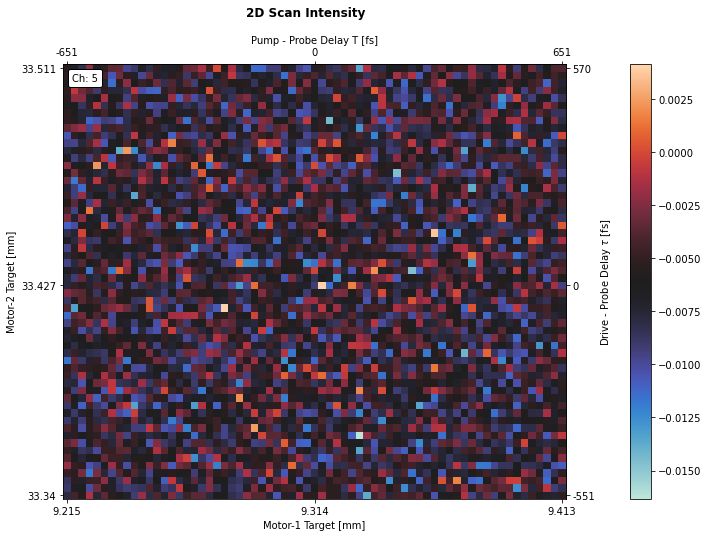

In [120]:
# Set figure size and instantiate Axis-class objects
fig, axs = plt.subplots(nrows = 1,
                        ncols = 1,
                        figsize = (10, 8));

# Choose colormap: Underscore-r "_r" reverses the cmap
mycmap = plt.get_cmap('icefire'); # Diverging color palette for readability

# Choose a channel to view
channel = 5

# Specify initial time-zero tick-position (1st guess midpoint of data)
tz1 = m1_tick_idx[1]
tz2 = m2_tick_idx[1]

# Display a 2D-Scan Intensity in each instance
hmap = axs.imshow(data_to_plot[channel],
                  #center=0,
                  #vmin=,
                  #vmax=,
                  origin='lower', # Orients hmap to increase upwards
                  cmap = mycmap); 

# Format tick-marks and tick-labels
# X-AXIS: Motor-1
axs.set_xticklabels(labels=motor1_labels,
                    rotation = 0,
                    rotation_mode='anchor',
                    ha='center');
axs.set_xticks(m1_tick_idx);
# Y-AXIS: Motor-2
axs.set_yticklabels(labels=motor2_labels,
                    rotation = 0,
                    rotation_mode='anchor',
                    ha='right');
axs.set_yticks(m2_tick_idx);

# CHILD-AXES: TICK FORMATTING
# T-AXIS: Motor-1 "Pump Delay"
T = axs.secondary_xaxis(location = 'top')
T.set_xticklabels(labels=T_labels,
                    rotation = 0,
                    rotation_mode='anchor',
                    ha='center');
T.set_xticks(m1_tick_idx);

# TAU-AXIS: Motor-2 "Drive Delay"
tau = axs.secondary_yaxis(location = 'right')
tau.set_yticklabels(labels=tau_labels,
                    rotation = 0,
                    rotation_mode='anchor',
                    ha='left');
tau.set_yticks(m2_tick_idx);

# Label Axes for map readability
axs.set_xlabel(f'Motor-1 Target [mm]')
axs.set_ylabel(f'Motor-2 Target [mm]')
T.set_xlabel('Pump - Probe Delay T [fs]')
tau.set_ylabel(r'Drive - Probe Delay $\tau$ [fs]')

# Now adding the colorbar
# [%(over from left), %(up from bottom), width=3%, height=75.4%]
cbar_pos = [0.95, 0.125, 0.03, 0.754]
cbaxes = fig.add_axes(cbar_pos)
cb = plt.colorbar(hmap,
             #pad = 0.5,
             cax = cbaxes)
# Draw inside label-channel indictor
draw_text(axs, channel)

fig.suptitle('2D Scan Intensity', fontweight ="bold");

#### Figure 1 with Plotly

[[ go back to the top ]](#Table-of-contents)

In [121]:
data_to_plot[0];

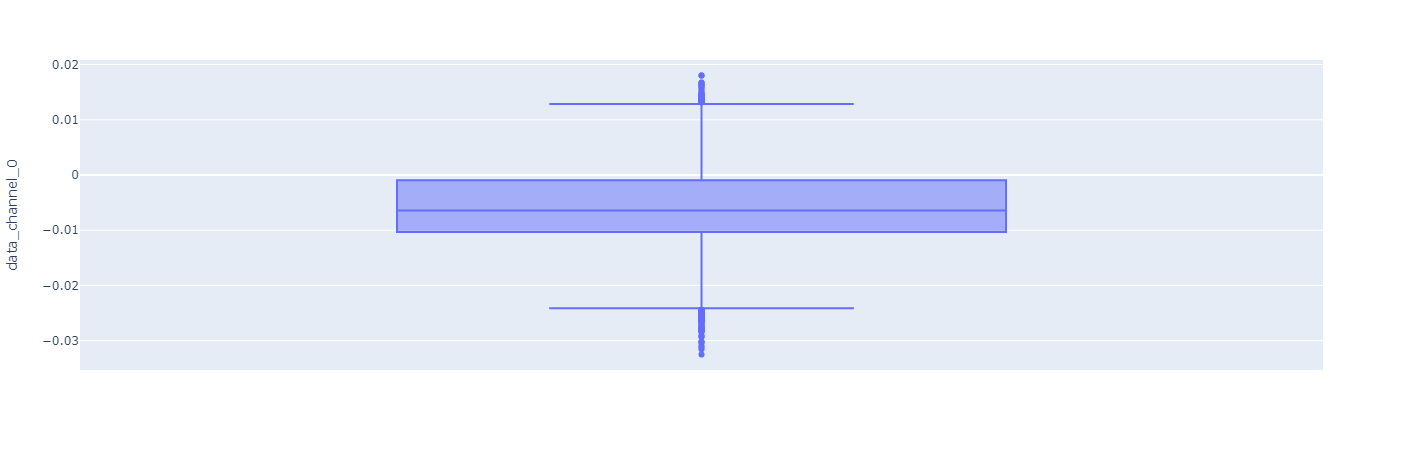

In [122]:
# Box (and Whisker) Plot 
import plotly.express as px
fig = px.box(data_frame=signal_df,
             y='data_channel_0',)
             #hover_data=[list of col names for outliers],
             #points=,
             #color='color_col',
             #hovertext=df['col_name']) 
#fig.write_html('first_figure.html', auto_open=True)
fig.show()

In [123]:
# Pre-Processing

# Start with Channel '0'
ch = 5 #for ch in len(8):
df = data_to_plot[ch]

num1_steps = len(df.columns)
num2_steps = len(df.index)

if (num1_steps%2) == 0:
    step1_zero = num1_steps/2
elif (num1_steps%2) != 0:
    step1_zero = (num1_steps-1)/2
    
if (num2_steps%2) == 0:
    step2_zero = num2_steps/2
elif (num2_steps%2) != 0:
    step2_zero = (num2_steps-1)/2
    
val1_zero = df.columns.to_list()[round(step1_zero)]
val2_zero = df.index.to_list()[round(step2_zero)]

topT_axis = ((df.columns-val1_zero)/step1_space)*step1_time
tauR_axis = ((df.index-val2_zero)/step2_space)*step2_time

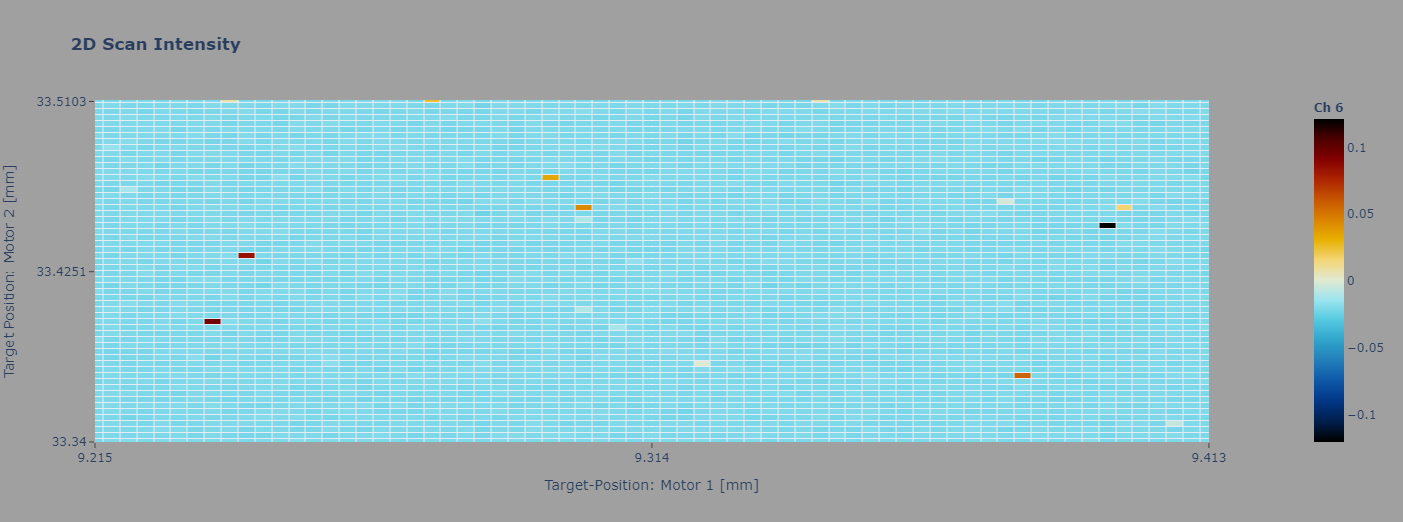

In [124]:
### import plotly.graph_objects as go
# go objects are grouped into 'one-indexed' subplot rows
# Set hmap magnification, fixed ratio
mag_factor = 9

# Set base figure for subplots
fig = make_subplots(rows = 1, #Display how many rows of objects 
                    cols = 1, #Display how many side-by-side?
                    #subplot_titles = [list_of_strings],
                    specs=[[{'secondary_y':True}]],
                    shared_xaxes = False,
                    shared_yaxes = False)

# Start with Channel '0'
ch = 6 #for ch in len(8):
df = data_to_plot[ch]

# Add heatmap trace to subplot
fig.add_trace(go.Heatmap(x = df.columns,
                         xgap = 1,
                         y = df.index,
                         ygap = 1,
                         z = df, # Signal data of channel = ch
                         zmin = signal_mins[ch], # Specify or plotly defaults to df min/max
                         zmid = 0,
                         #zmax = signal_maxs[ch],
                         colorbar_title = f'<b>Ch {ch}<b>',
                         colorbar_len = 1.06,
                                     #'xpad': 100},
                                     #'x': cbar_xlocs[ch],
                                     #'y': cbar_ylocs[ch],
                         colorscale ='icefire'),
              #row = mth_row,
              #col = nth_col,
              #name = f'Channel {ch}',
              secondary_y = False)

## Add secondary axes
#fig.add_trace(go.Heatmap(x = df.columns,
#                         y = tauR_axis, # Tau Delay-Axis (Motor-2), displayed 'Right'
#                         z = df, # Signal data of channel = ch
#                         #zmin = signal_mins[ch], # Specify or plotly defaults to df min/max 
#                         #zmax = signal_maxs[ch],
#                         colorscale = 'icefire'),
#              #row = mth_row,
#              #col = nth_col,
#              #yaxis = 'y2',
#              secondary_y = True)

# Format Axes
fig.update_layout(
                  {'xaxis':{'title' : {'text' : 'Target-Position: Motor 1 [mm]'},
                            'tickmode': 'linear',
                            'tick0': motor_labels[1][0],
                            'dtick': step1_space*num1_steps*.5,
                            'range' : [m1_position_min, m1_position_max] },
                   'yaxis':{'title' : {'text' : 'Target Position: Motor 2 [mm]'},
                            'tickmode': 'linear',
                            'tick0': motor_labels[2][0],
                            'dtick': step1_space*num1_steps*.43,
                            'range' : [m2_position_min, m2_position_max] },
                  },
                  paper_bgcolor = 'rgb(160,160,160)',
                  title_text = '<b>2D Scan Intensity<b>',
                  width = m1_step_count*mag_factor,
                  height = m2_step_count*mag_factor)

fig.update_xaxes(showticklabels=True, 
                 showgrid = True,
                 ticks = 'outside')
fig.update_yaxes(showticklabels=True, 
                 ticks = 'outside',
                 showgrid = True,
                 secondary_y = False)
fig.update_coloraxes(colorbar_xpad = 100)

#fig.update_yaxes(title_text = 'Time Delay: Drive to Probe [fs]',
#                 #showgrid = True,
#                 #showticklabels=True, 
#                 #ticks = 'outside',
#                 #tickson = 'boundaries',
#                 #ticklen = 10,
#                 secondary_y = True)

#fig.write_html('first_figure.html', auto_open=True)
# Draw inside label-channel indictor
fig.show()

In [125]:
len(data_to_plot)

8

In [126]:
motor_labels[1][0]

9.215

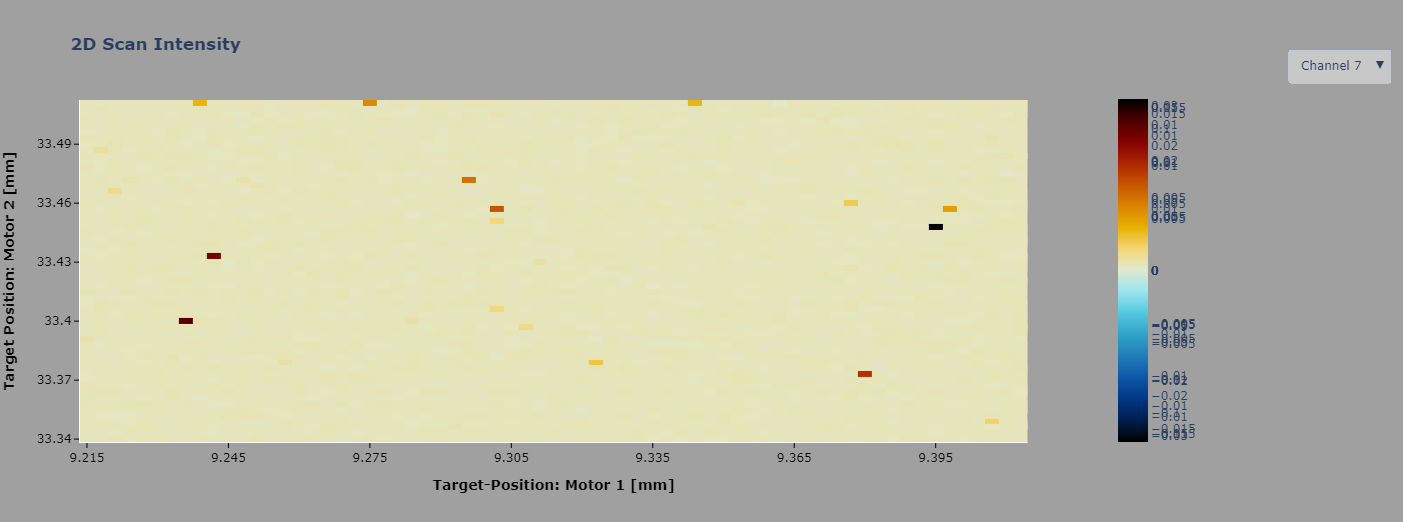

In [154]:
### import plotly.graph_objects as go
# go objects are grouped into 'one-indexed' subplot rows
# Set hmap magnification, fixed ratio
mag_factor = 9
# NOTE: Dropping additional channels in signal_df will remove them from this display
nchannels = len(signal_df.columns)

# Set base figure for subplots
fig = make_subplots(rows = 1, #Display how many rows of objects 
                    cols = 1, #Display how many side-by-side?
                    #subplot_titles = [list_of_strings],
                    specs=[[{'secondary_y':True}]],
                    shared_xaxes = False,
                    shared_yaxes = False)

# Add heatmap traces for each channel
for ch in range(nchannels):
    df = data_to_plot[ch]
    fig.add_trace(go.Heatmap(x = df.columns,
                             #xgap = 1,
                             y = df.index,
                             #ygap = 1,
                             z = df, # Signal data of channel = ch
                             zmin = signal_mins[ch], # Specify or plotly defaults to df min/max
                             zmid = 0,
                             #zmax = signal_maxs[ch],
                             #colorbar_title = f'<b>Ch {ch}<b>',
                             colorbar_tickcolor = 'black',
                             colorbar_len = 1.06,
                                         #'xpad': 100},
                                         #'x': cbar_xlocs[ch],
                                         #'y': cbar_ylocs[ch],
                             colorscale ='icefire'),
                  #row = mth_row,
                  #col = nth_col,
                  #name = f'Channel {ch}',
                  secondary_y = False)
#########################################################################################################################################
dropdown_buttons = []
for ch in range(nchannels):
    dropdown_buttons.append({'label': f'Channel {ch}',
                             'method': 'update',
                             'args': [
                                      {'visible': [idx==ch for idx in range(nchannels)] },
                                      {'title': '<b>2D Scan Intensity<b>'}
                                     ]
                            })

fig.update_layout(
                  {'updatemenus': [{'type': 'dropdown',
                                    'x': 1.3, # Position floats 
                                    'y': 1.15, # Position floats 
                                    'showactive': True, # Active buttons are highlighted
                                    'active': 7, # Determines initial 'active' channel
                                    'bgcolor': 'rgb(200,200,200)',
                                    'direction': 'down',
                                    'buttons': dropdown_buttons}] 
                  }) 
######################################################################################################################################
## Add secondary axes
#fig.add_trace(go.Heatmap(x = df.columns,
#                         y = tauR_axis, # Tau Delay-Axis (Motor-2), displayed 'Right'
#                         z = df, # Signal data of channel = ch
#                         #zmin = signal_mins[ch], # Specify or plotly defaults to df min/max 
#                         #zmax = signal_maxs[ch],
#                         colorscale = 'icefire'),
#              #row = mth_row,
#              #col = nth_col,
#              #yaxis = 'y2',
#              secondary_y = True)

# Format Axes
fig.update_layout(
                  {'xaxis':{'title' : {'text' : '<b>Target-Position: Motor 1 [mm]<b>'},
                            #'tickmode': 'auto',
                            #'nticks' : 4,
                            'ticks' : 'outside',
                            'tickson': 'boundaries',
                            'tick0': motor_labels[1][0],
                            'dtick': round(step1_space, 3)*10,# *num1_steps*.5,
                            'showticklabels': True,
                            'color' : 'black',
                            #'linecolor': 'black',
                            #'tickcolor': 'black',
                            'gridcolor': 'black',
                            'showline': True,
                            'showgrid': True,
                            'range' : [m1_position_min-(step1_space/2), m1_position_max+(step1_space/2)] },
                   'yaxis':{'title' : {'text' : '<b>Target Position: Motor 2 [mm]<b>'},
                            'tickmode': 'linear',
                            'color' : 'black',
                            'gridcolor': 'black',
                            'showgrid': True,
                            'tick0': motor_labels[2][0],
                            'dtick': round(step2_space, 3)*10,# *num1_steps*.43,
                            'showline': True,
                            'range' : [m2_position_min-(step2_space/2), m2_position_max+(step2_space/2)] },
                   'coloraxis':{'colorbar':{'xpad' : 300,
                                'ypad' : 300,
                                'bgcolor' : 'black',
                                'bordercolor' : 'black',
                                'outlinecolor' : 'black',
                                'tickcolor' : 'black'}},
                  },
                  paper_bgcolor = 'rgb(160,160,160)',
                  title_text = '<b>2D Scan Intensity<b>',
                  margin_autoexpand = True,
                  width = m1_step_count*mag_factor,
                  height = m2_step_count*mag_factor)

#fig.update_xaxes(showticklabels=True, 
                 #showgrid = True,)
                 #ticks = 'outside')
fig.update_yaxes(showticklabels=True, 
                 ticks = 'outside',
                 showgrid = True,
                 secondary_y = False)
fig.update_coloraxes(colorbar_xpad = 300,
                     colorbar_ypad = 300,
                     colorbar_bgcolor = 'black',
                     colorbar_bordercolor = 'black',
                     colorbar_outlinecolor = 'black',
                     colorbar_tickcolor = 'black')

#fig.update_yaxes(title_text = 'Time Delay: Drive to Probe [fs]',
#                 #showgrid = True,
#                 #showticklabels=True, 
#                 #ticks = 'outside',
#                 #tickson = 'boundaries',
#                 #ticklen = 10,
#                 secondary_y = True)

#fig.write_html('first_figure.html', auto_open=True)
fig.show()

### Dict-Style lookup
fig['layout'];

In [153]:
# Class-Property Access
fig.layout;

### motor_labels[1][0]

### Figure 1 previous version

[[ go back to the top ]](#Table-of-contents)

#### Multi-Plot: Matplotlib

[[ go back to the top ]](#Table-of-contents)

In [ ]:
# Figsize probably needs to be generalized to remove hardcoded dimensions

fig, axs = plt.subplots(nrows = 4,
                        ncols = 2,
                        sharex= True,
                        sharey=True,
                        figsize=(10,10))

#fig, ((ax0, ax1), (ax2, ax3), (ax4, ax5), (ax6, ax7)) = plt.subplots(nrows = 4,
#                                                                     ncols = 2,
#                                                                     figsize=(8, 5),
#                                                                     sharex=True,
#                                                                     sharey=True)

# Channels currently range from 0-7
channel = 0
# Define start of last row (figures displayed)
last_row = 6
# Identify min/max values in "signal-data"
#signal_df = data[['data_channel_0','data_channel_1','data_channel_2','data_channel_3','data_channel_4','data_channel_5','data_channel_6','data_channel_7']]
#v_min = min(signal_df.min())
#v_max = max(signal_df.max())

# Determine number of tick-labels desired on horizontal-axis
tick_label_count = 2

# Four rows may not always be desired
for row in range(0,4):
    # Two heatmaps side-by-side should generally be readible
    for col in range(0,2):
        # Display a 2D-Scan Intensity in each instance initialized by AxesGrid
        hmap = sns.heatmap(data_to_plot[channel],
                           #ax=axs[row][col],
                           ax=axs[row][col],
                           xticklabels = round(m1_step_count/tick_label_count),
                           yticklabels = round(m2_step_count/tick_label_count),
                           center=0, # Sets the center of cbar at zero
                           #vmin = v_min,# Sets cbar min for all subplots
                           #vmax = v_max,# Sets cbar max for all subplots
                           cmap = 'icefire'); # Diverging color palette for readability
        
        # Where should the CHANNEL be labeled?
        hmap.set_xlabel(f'Motor-1 Target [mm]')
        hmap.set_ylabel(f'Motor-2 Target [mm]')
        #hmap.set_title(f'Channel {channel}')
        draw_text(hmap, channel)

        # The vertical axis is shared in the call to subplots
        #if channel%2==0:
            # Clean vertical axis with fewer labels displayed
            #plt.setp(hmap.get_yticklabels()[::2], visible=False)
            
        # Hide y-axis labels and y-ticks in second column (sharey=True in subplots)
        if channel%2 != 0:
            plt.setp(hmap.get_yaxis(), visible=False);
            
        # Horizontal axis is shared 
        if channel < last_row:
            #hmap.set_xlabel('') # Removes xaxis-label if "plt.setp..."" is commented out below
            plt.setp(hmap.get_xaxis(), visible=False); #Hides ticks and axis-label, tick-label not visible either way
        # 
        if channel >= last_row:
            #plt.setp( hmap.get_xticklabels()[1::2], visible=False);
            plt.setp( hmap.get_xticklabels(), rotation = 0, rotation_mode='anchor', ha='left');
        # Increment channel for the next subplot    
        channel += 1
plt.tight_layout()

In [ ]:
### import plotly.graph_objects as go

#https://plotly.com/python-api-reference/generated/plotly.graph_objects.Figure.html
#https://plotly.github.io/plotly.py-docs/generated/plotly.graph_objects.Heatmap.html
#https://plotly.com/python-api-reference/generated/plotly.graph_objects.Layout.html#plotly.graph_objects.Layout
#https://plotly.com/python-api-reference/generated/plotly.subplots.make_subplots.html
#https://plotly.com/python/tick-formatting/
# go objects are grouped into 'one-indexed' subplot rows
#mth_row = 1
#nth_col = 1
#for row
# Set base figure for subplots
fig = make_subplots(rows = 4, #Display how many rows of objects 
                    cols = 2, #Display how many side-by-side?
                    subplot_titles = ['Ch 0', 'Ch 1', 'Ch 2', 'Ch 3',
                                      'Ch 4', 'Ch 5', 'Ch 6', 'Ch 7'],
                    #specs=[[{'secondary_y':False}, {'secondary_y':False}],
                    #       [{'secondary_y':False}, {'secondary_y':False}],
                    #       [{'secondary_y':False}, {'secondary_y':False}],
                    #       [{'secondary_y':False}, {'secondary_y':False}] ],
                    shared_xaxes = 'all',
                    shared_yaxes = 'all',
                    x_title = '<b>Target-Position: Motor 1 [mm]<b>',
                    y_title = '<b>Target Position: Motor 2 [mm]<b>',
                    print_grid = True,
                    start_cell = 'top-left')

###################################################################################################
loc_dict = {0: [1,1], 1: [1,2],
            2: [2,1], 3: [2,2],
            4: [3,1], 5: [3,2],
            6: [4,1], 7: [4,2]}

cbar_xlocs = [0.44, 0.99, 0.44, 0.99, 0.44, 0.99, 0.44, 0.99]
cbar_ylocs = [0.925, 0.925, 0.64, 0.64, 0.36, 0.36, 0.08, 0.08]

for ch in range(8):
    df = data_to_plot[ch]
    # Add heatmap trace to subplot
    fig.add_trace(go.Heatmap(x = df.columns,
                             #xaxis = 'x',
                             xgap = 0,
                             y = df.index,
                             #yaxis = 'y',
                             ygap = 0,
                             z = df, # Signal data of channel = ch
                             zmin = signal_mins[ch], # Specify or plotly defaults to df min/max
                             zmax = signal_maxs[ch],
                             colorscale = 'icefire',
                             colorbar = {'title': f'Ch {ch}',
                                         'len': 0.19,
                                         'x': cbar_xlocs[ch],
                                         'y': cbar_ylocs[ch]},
                             showscale = True),
                  row = loc_dict[ch][0],
                  col = loc_dict[ch][1],
                  secondary_y = False)
    # Format Axes
    fig.update_layout({'title':{'text': '<b>2D Scan Intensity<b>'},
                       'xaxis':{'tickmode': 'linear',
                                'tick0': motor_labels[1][0],
                                'dtick': step1_space*num1_steps*.5,
                                'range' : [m1_position_min, m1_position_max] },
                       'yaxis':{'tickmode': 'linear',
                                'tick0': motor_labels[2][0],
                                'dtick': step1_space*num1_steps*.43,
                                'range' : [m2_position_min, m2_position_max] },
                      },
                      width = 800, #m1_step_count*mag_factor,
                      height = 600, #m2_step_count*mag_factor,
                      title_text = '<b>2D Scan Intensity<b>')
###################################################################################################
# # Add secondary axes
# fig.add_trace(go.Heatmap(x = df.columns,
#                          y = tauR_axis, # Tau Delay-Axis (Motor-2), displayed 'Right'
#                          z = df, # Signal data of channel = ch
#                          #zmin = signal_mins[ch], # Specify or plotly defaults to df min/max 
#                          #zmax = signal_maxs[ch],
#                          colorscale = 'icefire'),
#               row = mth_row,
#               col = nth_col,
#               secondary_y = True)

# # Format Axes
# fig.update_layout({'title':{'text': '<b>2D Scan Intensity<b>'},
#                    'xaxis':{'title' : {'text' : 'Target-Position: Motor 1 [mm]'},
#                             'tickmode': 'linear',
#                             'tick0': motor_labels[1][0],
#                             'dtick': step1_space*num1_steps*.5,
#                             'range' : [m1_position_min, m1_position_max] },
#                    'yaxis':{'title' : {'text' : 'Target Position: Motor 2 [mm]'},
#                             'tickmode': 'linear',
#                             'tick0': motor_labels[2][0],
#                             'dtick': step1_space*num1_steps*.43,
#                             'range' : [m2_position_min, m2_position_max] },
#                   }, height = 600, width = 800, title_text = '<b>2D Scan Intensity<b>')


#fig.update_yaxes(title_text = 'Time Delay: Drive to Probe [fs]', secondary_y = True)
fig.update_xaxes(#showticklabels=True, 
                 ticks = 'outside')
fig.update_yaxes(#showticklabels=True, 
                 ticks = 'outside')

#fig.write_html('first_figure.html', auto_open=True)
# Draw inside label-channel indictor
fig.show()

[[ go back to the top ]](#Table-of-contents)

In [ ]:
# Figsize probably needs to be generalized to remove hardcoded dimensions
fig = plt.figure(num='2D Scan Intensity', figsize=(16,11))

# Channels currently range from 0-7
channel = 0
# Identify min/max values in "signal-data"
# Re-write this code to give user easy option for selecting the two "dead" channels to exclude
signal_df = data[['data_channel_0','data_channel_1','data_channel_2','data_channel_3','data_channel_4','data_channel_5']]
v_min = min(signal_df.min())
v_max = max(signal_df.max())
#############################################################################################################################
# Import axes_grid1 toolkit to display multiplot w/ AxesGrid helper class
from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.axes_grid1 import host_subplot

# Initialize AxesGrid, instantiate all "subplot" axes
grid = AxesGrid(fig, 
                120, # Similar to subplot(120)
                label_mode = 'L', # Display tick-labels at LEFT & BTTM locations only
                add_all = True, # False doesn't show subplots
                aspect = True, # True: widths & heights scaled according to data lims, False loses square shape
                #share_all=True, # xaxis & yaxis of all axes shared
                nrows_ncols=(4, 2), # Creates a 4x2 grid of axes
                axes_pad=0.5, # Pad b/w axes[inch]
                #cbar_pad=1.5, # Pad b/w cbar and axis[inch]
                #cbar_location='right',
                #cbar_set_cax = True, # Doesn't seem to make a difference
                cbar_mode='single') # The AxesGrid cbar is empty for some reason
#############################################################################################################################
for axs in grid:
    #axs.set_axis_off()
    # Display a 2D-Scan Intensity in each instance initialized by AxesGrid
    hmap = sns.heatmap(data_to_plot[channel],
                       #ax = axs,
                       ax = grid[channel],
                       xticklabels = 22,
                       #xticklabels = round(m1_step_count/tick_label_count),
                       yticklabels = 16,
                       #yticklabels = round(m2_step_count/tick_label_count),
                       center = 0, # Sets the center of cbar at zero
                       vmin = v_min, # Sets cbar min for all subplots
                       vmax = v_max, # Sets cbar max for all subplots
                       cbar = True,
                       #cbar_ax = grid[channel],
                       cmap = 'icefire'); # Diverging color palette for readability
    
    #host = host_subplot(fig, 1,2,0)
    #tau = axs
    #tau.set_ylim(0, step2_time*m2_step_count)
    #axs.callbacks.connect("ylim_changed", tau.figure.canvas.draw())
    #tau.set_ylabel('Time Delay: Tau (Drive/Probe)') 

    # Where should the CHANNEL be labeled?
    hmap.set_xlabel(f'Motor-1 Target [mm]')
    hmap.set_ylabel(f'Motor-2 Target [mm]')
    #hmap.set_title(f'Channel {channel}')
    draw_text(axs, channel)

    # The vertical axis is shared in the call to subplots
    if channel%2==0:
        # Clean vertical axis with fewer labels displayed
        plt.setp(hmap.get_yticklabels()[::2],
                 rotation = 0,
                 visible=False)
    elif channel%2!=0:
        plt.setp(hmap.get_yaxis(), visible=False);
        #plt.yticks(ticks=[])
        #hmap.set_yticks([])

    # Horizontal axis is shared 
    if channel < last_row:
        #hmap.set_xlabel('')
        #plt.xticks(ticks=[])
        plt.setp(hmap.get_xaxis(), visible=False);
    # 
    if channel >= last_row:
        plt.setp([hmap.get_xticklabels()[1::2]], visible=False);
        plt.setp( hmap.get_xticklabels()[1::2], visible=False);
        plt.setp( hmap.get_xticklabels()[1::2], visible=False);
        plt.setp( hmap.get_xticklabels(), 
                 #rotation_mode='anchor', 
                 ha='left',
                 rotation = 0);
    # Increment to next channel and repeat for all 8 channels
    channel += 1

In [ ]:
signal_cols = [col_name for col_name in data if 'data_channel' in col_name]
signal_df = data[data_cols].copy()
display(signal_df.max())
signal_df.drop(columns = ['data_channel_6', 'data_channel_7'], inplace = True)

#### Normalized Scale

[[ go back to the top ]](#Table-of-contents)

In [ ]:
# Figsize probably needs to be generalized to remove hardcoded dimensions
#import mpl_toolkits.axisartist as AA
from mpl_toolkits.axes_grid1 import AxesGrid
#from mpl_toolkits.axes_grid1 import host_subplot

fig = plt.figure(num='2D Scan Intensity', figsize=(16,11))

# Identify min/max values in "signal-data"
# Re-write this code to give user easy option for selecting the two "dead" channels to exclude
signal_df = data[['data_channel_0','data_channel_1','data_channel_2','data_channel_3','data_channel_4','data_channel_5']]
v_min = min(signal_df.min())
v_max = max(signal_df.max())

# Initialize AxesGrid, instantiate all "subplot" axes
grid = AxesGrid(fig, 
                111, # Similar to subplot(111)
                label_mode = 'L', # Display tick-labels at LEFT & BTTM locations only
                add_all = True, # False doesn't show subplots
                aspect = True, # True: widths & heights scaled according to data lims, False
                share_all=True, # xaxis & yaxis of all axes shared
                nrows_ncols=(4, 2), # Creates a 4x2 grid of axes
                axes_pad=0.5, # Pad b/w axes[inch]
                cbar_pad=2.0, # Pad b/w cbar and axis[inch]
                #cbar_location='right',
                cbar_set_cax = True, # Doesn't seem to make a difference
                #axes_class = AA.Axes,
                cbar_mode='None') # The AxesGrid cbar is empty for some reason

# Generate a heatmap for each channel
for channel in range(8):
#for channel in range(8):
    # Display a 2D-Scan Intensity in each instance initialized by AxesGrid
    hmap = sns.heatmap(data_to_plot[channel],
                       #ax = axs,
                       ax = grid[channel],
                       xticklabels = 22,
                       #xticklabels = round(m1_step_count/tick_label_count),
                       yticklabels = 16,
                       #yticklabels = round(m2_step_count/tick_label_count),
                       center = 0, # Sets the center of cbar at zero
                       vmin = v_min, # Sets cbar min for all subplots
                       vmax = v_max, # Sets cbar max for all subplots
                       cbar = True,
                       #cbar_ax = grid[channel],
                       cmap = 'icefire'); # Diverging color palette for readability

    # Where should the CHANNEL be labeled?
    hmap.set_xlabel(f'Motor-1 Target [mm]')
    hmap.set_ylabel(f'Motor-2 Target [mm]')
    #hmap.set_title(f'Channel {channel}')
    draw_text(hmap, channel)

    # Restrict xticks & xlabels to final-row subplots only
    if channel < last_row:
        plt.setp(hmap.get_xaxis(), visible=False);
    # Restrict yticks & ylabels to 1st-column subplots only
    if channel%2 != 0:
        plt.setp(hmap.get_yaxis(), visible=False);

    # Re-position xtick-labels
    if channel >= last_row:
        plt.setp(hmap.get_xticklabels(), 
                 #rotation_mode='anchor', 
                 ha='left',
                 rotation = 0);
    # Re-position ytick labels
    if channel%2 == 0:
        plt.setp(hmap.get_yticklabels(),
                 rotation = 0);